In [1]:
!pip uninstall -y eonacs && pip install  git+https://github.com/njnmco/smc #--log /dev/stderr

Found existing installation: eonacs 1.0.0
Uninstalling eonacs-1.0.0:
  Successfully uninstalled eonacs-1.0.0
  Cloning https://github.com/njnmco/smc to /tmp/pip-req-build-zm4x7sxh
  Running command git clone -q https://github.com/njnmco/smc /tmp/pip-req-build-zm4x7sxh
  Created wheel for eonacs: filename=eonacs-1.0.0-py3-none-any.whl size=1899 sha256=b50da3bd4972a735f3c69226d171906234817cb6177212f4b497497612794b19
  Stored in directory: /tmp/pip-ephem-wheel-cache-80xc441s/wheels/6e/02/6d/470a51584ecf5233c1da27aab5d5e137df8b9ab9cc345b2a49
Successfully built eonacs


In [72]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,15)


In [2]:
import eonacs.common.util as util

util.colab_map_drive()


Mounted at /content/drive


In [3]:
con = util.onet_db()

In [4]:
import pandas as pd
import numpy as np
import torch

In [5]:
tasks = pd.read_sql("select task from task_statements",   con)

In [6]:
tasks


,task
0,Direct or coordinate an organization's financi...
1,Appoint department heads or managers and assig...
2,Analyze operations to evaluate performance of ...
3,"Direct, plan, or implement policies, objective..."
4,"Prepare budgets for approval, including those ..."
...,...
19254,Unload cars containing liquids by connecting h...
19255,"Clean interiors of tank cars or tank trucks, u..."
19256,Lower gauge rods into tanks or read meters to ...
19257,Operate conveyors and equipment to transfer gr...


In [7]:
dwa = pd.read_sql("select dwa_title from dwa_reference",   con)

In [8]:
dwa

,dwa_title
0,Review art or design materials.
1,Study details of musical compositions.
2,Review production information to determine cos...
3,Study scripts to determine project requirements.
4,Review audio or video recordings.
...,...
2082,Monitor availability of equipment or supplies.
2083,Inventory materials or equipment.
2084,Inventory medical supplies or equipment.
2085,Monitor inventories of products or materials.


In [9]:
import eonacs.common.dbert as dbert
tokenizer, model = dbert.dbert()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
dwa_tok = dwa['dwa_title'].apply(tokenizer.encode)

In [18]:
dwa_tok.apply(lambda x, max_width: x.extend([0]*(max_width - len(x))), max_width=dwa_tok.apply(len).max()    )

0       None
1       None
2       None
3       None
4       None
        ... 
2082    None
2083    None
2084    None
2085    None
2086    None
Name: dwa_title, Length: 2087, dtype: object

In [19]:
dwa_tok[1]

[101,
 2817,
 4751,
 1997,
 3315,
 9265,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [97]:
X = np.array(dwa_tok.to_list())

In [98]:
X[1,]

array([ 101, 2817, 4751, 1997, 3315, 9265, 1012,  102,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [99]:
input_ids = torch.tensor(X)  
attention_mask = torch.tensor(np.where(X != 0, 1, 0))


In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
model = model.to(device)



with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

cpu


In [102]:
features = last_hidden_states[0][:,0,:].cpu().numpy()

In [103]:
#!pip install umap-learn

In [104]:
import umap
from sklearn.preprocessing import StandardScaler

In [105]:
scale = StandardScaler()

features = scale.fit_transform(features)


In [106]:
reducer = umap.UMAP()

In [107]:
embedding = reducer.fit_transform(features)

In [108]:
embedding.shape

(2087, 2)

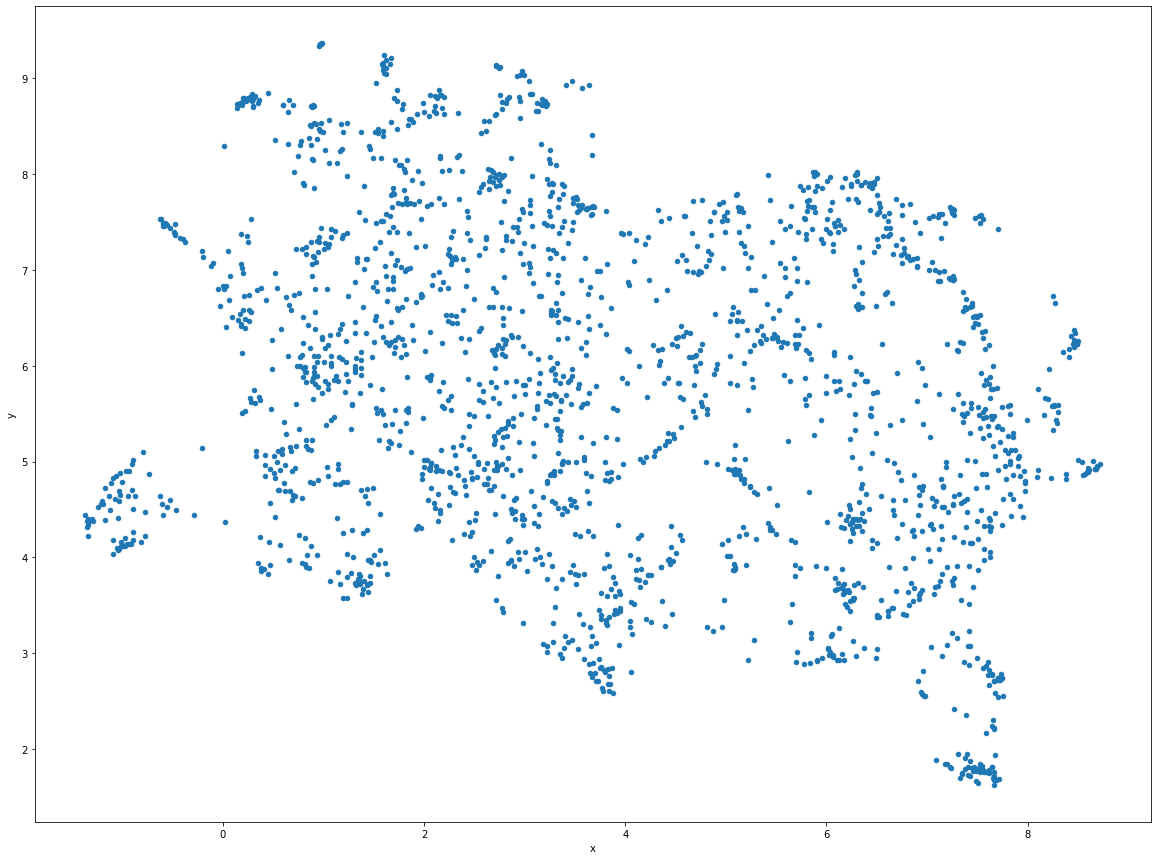

In [109]:
pd.DataFrame(embedding, columns=['x','y']).plot.scatter('x', 'y')

In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

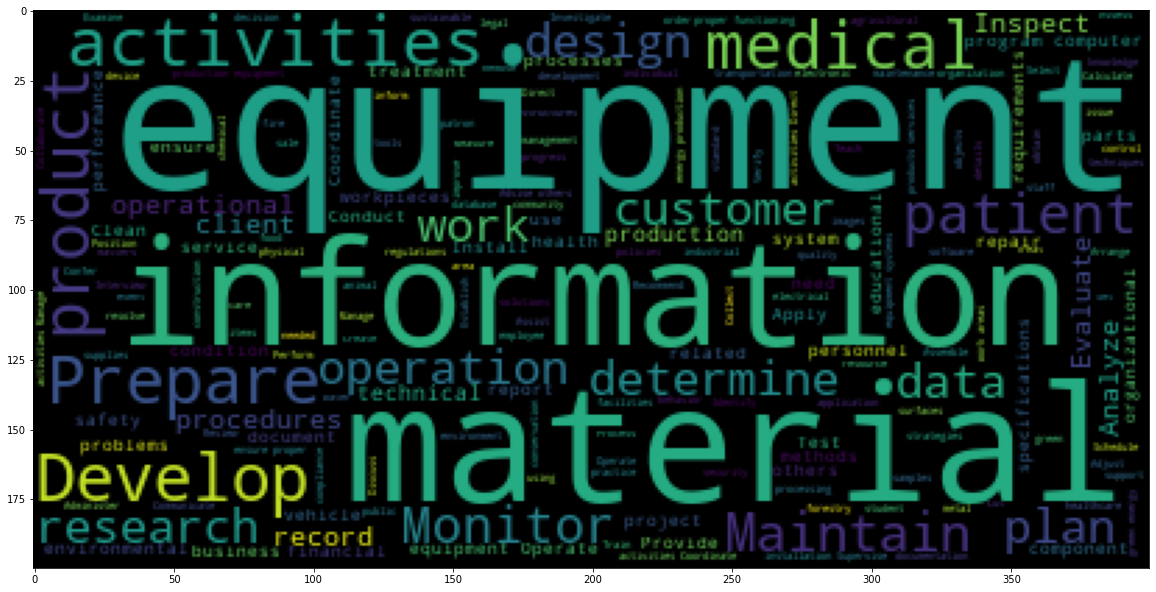

In [74]:

plt.imshow(
    WordCloud().generate_from_text(" ".join(dwa['dwa_title']))
)

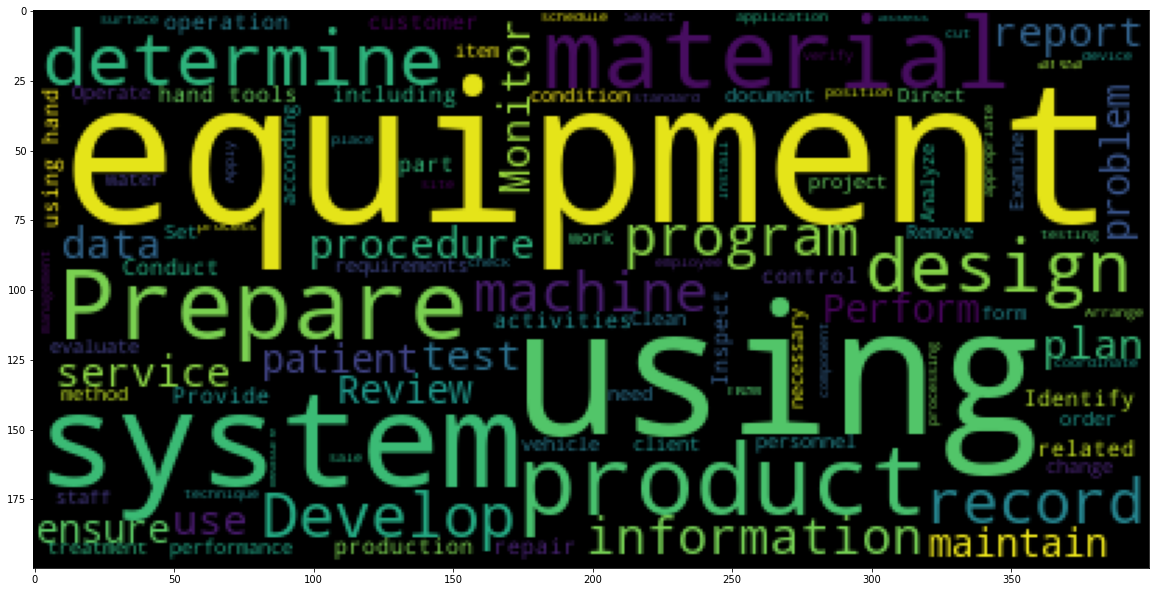

In [75]:
plt.imshow(
    WordCloud().generate_from_text(" ".join(tasks['task']))
)

## SMC

In [49]:
def get_json(f):
  return json.load(open(f))

In [51]:
import os, glob

In [58]:
courses = [get_json(f) for f in glob.glob("/content/drive/MyDrive/smc/data/curricunet/*reportId=5.json") ]

In [59]:
courses[1]

{'course': 'COMPUTER SCIENCE 34A, Game Programming 1',
 'course_objectives': ['Demonstrate an understanding and applications of the asset workflow model',
  'Create a game play',
  'Use 2D and graphics in game development',
  'Use 3D physics in game development',
  'Apply event driven programming to develop games',
  'Apply audio, music and animation in navigation',
  'Adapt games for different platforms such as Mobile devices'],
 'file': 'data/curricunet/3064?reportId=5',
 'student_learning_outcomes': ['Using the principles of Programming, graphics in 2D and 3D and animation, students will develop interactive video games.',
  'Using the tools of a game development tool, students will debug code for logical, syntax and runtime errors.']}

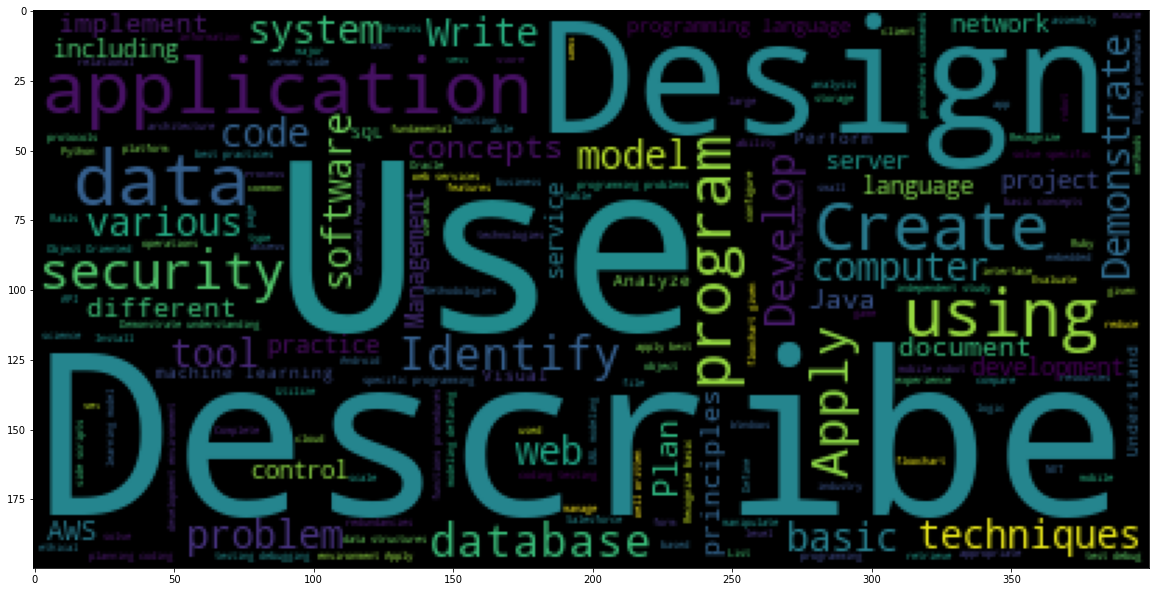

In [76]:
plt.imshow(
    WordCloud().generate_from_text(" ".join(" ".join(x['course_objectives']) for x in courses))
)

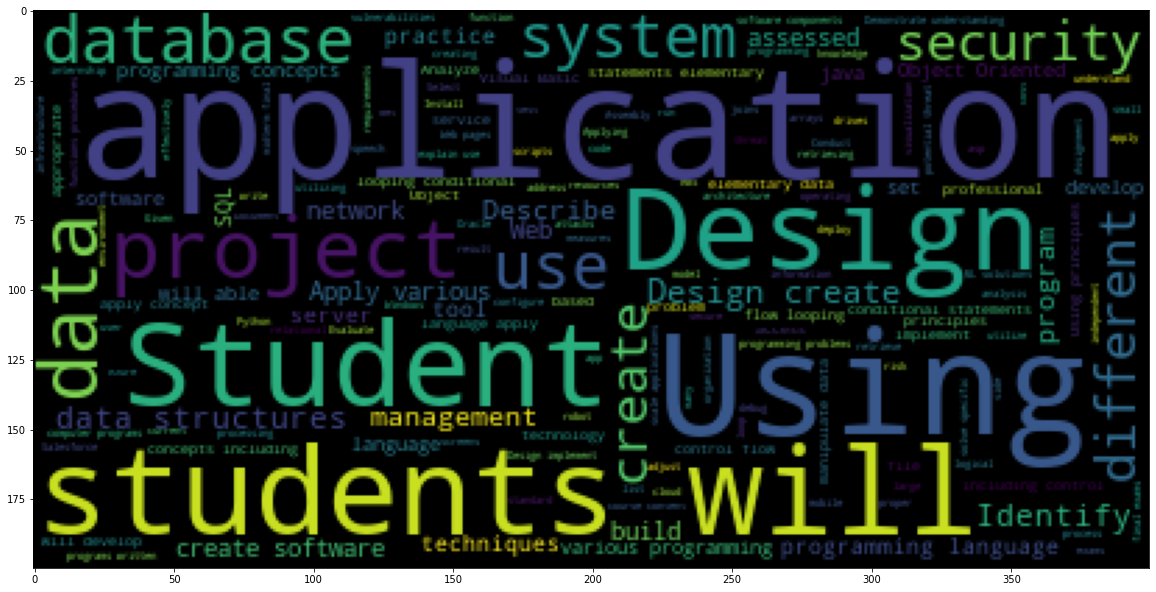

In [77]:
plt.imshow(
    WordCloud().generate_from_text(" ".join(" ".join(x['student_learning_outcomes']) for x in courses))
)

In [81]:
tech = pd.read_sql("select example, count(1) as n from technology_skills group by 1 order by 2 desc limit 50", con)

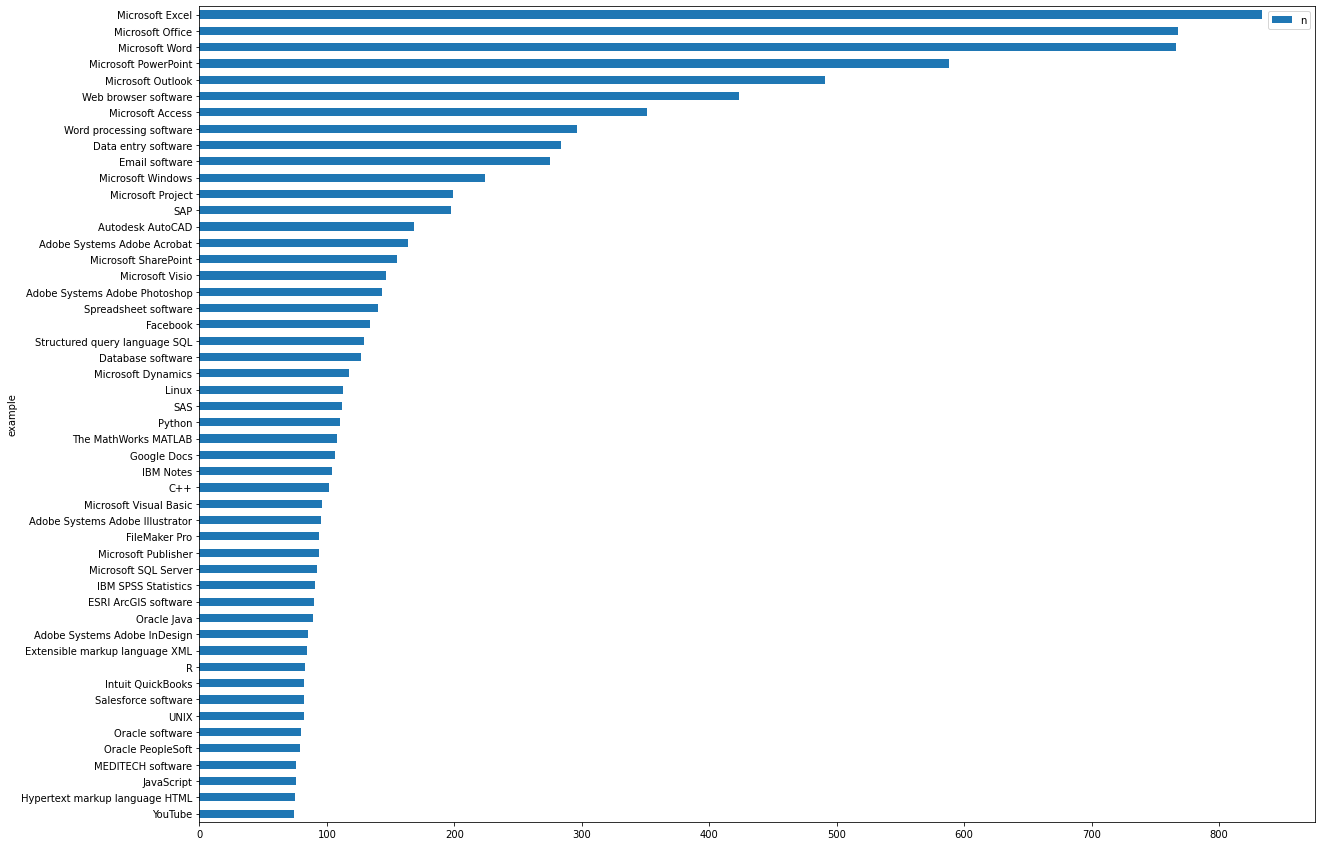

In [85]:
tech.sort_values("n", ascending=True).plot.barh("example", "n")

In [131]:
slos = pd.Series([x for i in courses for x in i["student_learning_outcomes"] ])

In [90]:
slos = slos.apply(tokenizer.encode)

In [91]:
slos.apply(lambda x, max_width: x.extend([0]*(max_width - len(x))), max_width=slos.apply(len).max()    )

0      None
1      None
2      None
3      None
4      None
       ... 
164    None
165    None
166    None
167    None
168    None
Length: 169, dtype: object

In [110]:
X = np.array(slos.to_list())

In [111]:
X[1,]

array([  101,  2640,  1998,  3443,  8484,  2007,  1996,  5650,  4730,
        4044,  1012,  2004, 14155,  2011,  1024, 19453,  1010,  3054,
        3334,  2213,  1998,  2345, 13869,  1012,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [112]:
input_ids = torch.tensor(X)  
attention_mask = torch.tensor(np.where(X != 0, 1, 0))


In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
model = model.to(device)



with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

cpu


In [114]:
features = last_hidden_states[0][:,0,:].cpu().numpy()

In [115]:
e2 = reducer.transform(scale.transform(features))

In [116]:
import plotnine as p9

In [117]:
df1 = pd.DataFrame(embedding, columns=['x','y'])
df1['type'] = 'DWA'
df2 = pd.DataFrame(e2, columns=['x','y'])
df2['type'] = 'SLO'


In [118]:
df = pd.concat([df1, df2])

In [120]:
df.tail()

,x,y,type
164,4.726456,5.039694,SLO
165,2.931930,5.930508,SLO
166,3.966269,5.433247,SLO
167,5.017881,5.110012,SLO
168,4.940931,4.988190,SLO


In [122]:
df1.shape

(2087, 3)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


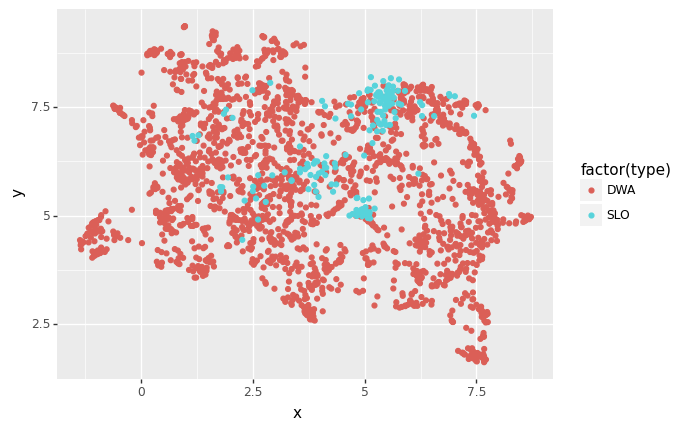

<ggplot: (8731901257353)>

In [123]:
p9.ggplot(df) + p9.aes(x='x', y='y', color='factor(type)') + p9.geom_point()

In [129]:
df1['dwa'] = dwa

In [130]:
df1.query('4.9 <= x & x <= 5.1 & 4.9 <= y & y <= 5.1')

,x,y,type,dwa
630,4.907259,4.980090,DWA,Create databases to store electronic data.
690,5.094110,4.919619,DWA,Create electrical schematics.
693,5.062411,4.914909,DWA,Create schematic drawings for electronics.
948,5.081304,5.029748,DWA,Assemble structural components.
1229,5.020627,4.920895,DWA,Create advanced digital images of patients usi...


In [132]:
df2['slo'] = slos

In [133]:
df2.query('4.9 <= x & x <= 5.1 & 4.9 <= y & y <= 5.1')

,x,y,type,slo
24,5.068143,4.974126,SLO,Apply various programming concepts including c...
25,4.970777,5.018903,SLO,Design and create programs written in Assembly...
79,5.036786,5.038258,SLO,Apply various programming concepts including c...
81,5.069489,4.947390,SLO,Create data visualizations using R scripts.
127,4.982768,5.054138,SLO,Design and create programs written in C#.
128,4.969381,5.048472,SLO,Design and create applications using the Ruby ...
131,4.928298,5.077184,SLO,Use UML to formally create design documents an...
133,5.093044,4.988799,SLO,Design and create Windows-based Graphical User...
141,5.047475,5.085677,SLO,"Build an Arithmetic Logic Unit, a full adder, ..."
168,4.940931,4.988190,SLO,Design and create programs written in Assembly...
